# Kalman Filter

In [29]:
import numpy as np
import matplotlib.pyplot as plt

## Filtering for a random walk
Recall that a Kalman filter can be used if both transition and emission densities are linear Gaussians. These models are usually referred to as linear dynamical models (LDS). In particular, we will consider the following model:
\begin{eqnarray}
p(x_t | x_{t-1} ) & = & \mathcal{N} \left(x_t ; F x_{t-1}, Q \right) \\
p(t_t | x_{t} ) & = & \mathcal{N} \left(y_t ; H x_{t}, R \right)
\end{eqnarray},
where Q and R are noise \emph{covariances}.

As a first example, let us consider a very simple, one-dimensional random walk model.

In [30]:
# the dictionary that contains all the parameters for the LDS
params = {
    "F": 1,
    "Q": 1,
    "H": 1,
    "R": 10,
    "mu0": 10, # initial mean
    "Sigma0": 2, # initial variance
    "T": 50
}

We will now generate some artificial data from this generative model, i.e. we will create a trajectory $x_{0:t}$ and observations $y_{1:t}$. Note that the np.random.normal takes the _standard deviation_ as an input, which is why we have to compute the square root of the covariances when drawing samples from the generative model.

In [31]:
def KF1D_generateData(params):
    
    x = np.zeros(params["T"]+1)
    y = np.zeros(params["T"]+1)
    
    # initialization: draw samples from the initial distribution
    x[0] = np.random.normal(params["mu0"],np.sqrt(params["Sigma0"]))
    
    for i in range(1,params["T"]+1):
        # propagate the latent variable
        x[i] = np.random.normal(params["F"] * x[i-1],np.sqrt(params["Q"]))
        # draw an observation from the current state
        y[i] = np.random.normal(params["H"] * x[i], np.sqrt(params["R"]))
    
    
    return x, y


# generate a sample trajectory
np.random.seed(42) # for reproducibility ;)
x, y = KF1D_generateData(params)

In a filtering task, we don't have access to the latent trajectory $x_{0:t}$, but only to the sequence of observations. The goal is to estimate $x_{0:t}$ based on these observations alone. More precisely, a full solution to the filtering task is given by the filtering distribution (or posterior) $p(x_t | y_{1:t})$.
Let us first code up a Kalman filter (see pdf, algorithm 1) and let's run it by feeding it with the observations:

In [32]:
def KF1D(y,params):
    
    # unpack some parameters for readibility
    H = params["H"]
    F = params["F"]
    
    
    # initialize mu and Sigma
    mu = np.zeros(params["T"]+1)
    Sigma = np.zeros(params["T"]+1)  
    
    # the initial mean and variance are model parameters
    mu[0] = params["mu0"]
    Sigma[0] = params["Sigma0"]    
    
    for t in range(1,params["T"]+1):
        
        # compute variance of prediction density P. In the first iteration, P = Sigma0
        if t == 1:
            P = params["Sigma0"]
        else:
            P = F * Sigma[t-1] * F + params["Q"]
            
        # compute Kalman gain
        K = P * H * (H * P * H + params["R"])**(-1)
        
        # propagate mean and variance
        mu[t] = F * mu[t-1] + K * (y[t] - H * F * mu[t-1])
        Sigma[t] = (1 - K * H ) * P
            
    
    return mu, Sigma

# run the KF
mu, Sigma = KF1D(y,params)

Not let us plot the result of the filtering. We also want to compare the filter estimate (mean) with the ground truth trajectory $x_{0:t}$

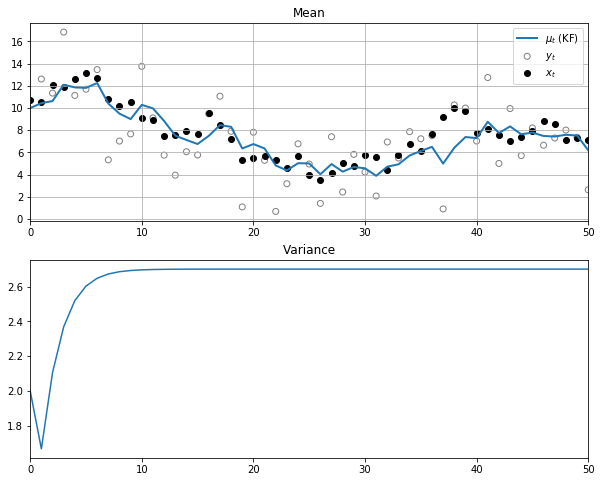

In [35]:
# Plot the trajectory and the observations
# (assume no observation at y = 0 )

t = np.arange(params["T"]+1)


fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,8))

# plots the filter estimate, the observations and the ground truth trajectory
ax1.scatter(t[1:],y[1:],color='grey',facecolors='none')
ax1.scatter(t,x,color='black')
ax1.plot(t,mu,linewidth=2)
ax1.legend([r'$\mu_t$ (KF)',r'$y_t$',r'$x_t$'])
ax1.grid(True)
ax1.set_xlim(0,50)
ax1.set_title('Mean')

# plots the KF variance. Note that it becomes stationary.
ax2.plot(t,Sigma)
ax2.set_xlim(0,50)
ax2.set_title('Variance')

plt.show()

## Filtering in dynamical systems 
The previous example was a super artificial toy example to get you started quickly and help you get an intiution what the task is. Let us now consider a more realistic example (which is related to the kind of applications that led to the invention of Kalman filters in the early 60s): tracking a moving object (e.g. a Soviet party balloon, to give it the right historical context and reasons why Kalman filters were invented in the first place. To be fair, it was also used for "lunar vehicle navigation"), which is governed by the follwing dynamical system:
\begin{eqnarray}
\dot{x}_t &=& v_t, \\
\dot{v}_t &=& - \frac{1}{\tau} v_t + \eta_t.
\end{eqnarray}
So our latent space has two dimensions: $x_t$ and $v_t$. Note that $v_t$ has an exponential decay component with time constant $\tau$ (e.g. due to friction) and is also subject to a white noise random force $\eta_t$ (e.g. divine intervention).
Further, we assume that the only information you have about the balloon is some noisy position observation. In order to pop the balloon, you task is now to estimate its position given the noisy evidence.

As a first step, let us discretize the system to formulate the generative model. For this, note that $\dot{x}_t = \frac{x_t - x{t-1}}{dt}$, where $dt$ is the time unit of the step size. Hence
\begin{eqnarray}
x_t & = & x_{t-1} + v_t \, dt, \\
v_t & = & v_{t-1} - \frac{1}{\tau} v_{t-1} + \eta_t.
\end{eqnarray}
Further, the emission model is a Gaussian wrt x as before.

Let us translate this to our go-to model parameters. Please take a moment to rethink where the parameters are coming from and why they have this particular shape.

In [19]:
dt = 0.1
params = {
    "dim_x": 2,
    "dim_y": 1,
    "F": np.array([[1, dt],
                   [0,  (1-dt)]]),
    "Q": np.array([[0, 0],
                   [0, 1 * dt]]),
    "H": np.array([[1, 0]]),
    "R": np.array([[1/dt]]),
    "mu0": np.array([0,0]),
    "Sigma0": np.array([[0, 0],
                   [0, 1]]),
    "T": int(100/dt)
}

You might have noticed the $dt$ scaling in the noise covariances. To give a back-of-the-envelope explanation: The variance of the transition model has to scale with $dt$ in order to keep the integrated white noise scale-invariant. The observation noise covariance scales inversely with the time step: The smaller I make the time step, the less informative a single observation becomes. On the other hand, I also have more observations per unit time, so this scaling prevents oversampling the observations and thus making the inference trivial. If you don't believe this, let's stick with divine intervention.

Now we generate artificial data from this process:

In [25]:
def KFmv_generateData(params):
    
    # unpack some parameters for readibility
    H = params["H"]
    F = params["F"]

    x = np.zeros([params["T"]+1,params["dim_x"]])
    y = np.zeros([params["T"]+1,params["dim_y"]])

    # initialization
    x[0] = np.random.multivariate_normal(params["mu0"],params["Sigma0"])

    for i in range(1,params["T"]+1):
        x[i] = np.random.multivariate_normal(np.dot(F,x[i-1]),params["Q"]) # no square root now, bc multivariate_normal
        y[i] = np.random.multivariate_normal(np.dot(H,x[i]), params["R"])
    
    
    return x, y


np.random.seed(42)
# generate the data
x, y = KFmv_generateData(params)

And now let's code up the multivariate Kalman filter. You don't have to do it again if your 1D code was general enough :)

In [26]:
def KFmv(y,params):
    
    # unpack some parameters for readibility
    H = params["H"]
    F = params["F"]


    # initialize mu and Sigma
    mu = np.zeros([params["T"]+1,params["dim_x"]])
    mu[0] = params["mu0"]
    Sigma = np.zeros([params["T"]+1,params["dim_x"],params["dim_x"]])
    Sigma[0] = params["Sigma0"]

    for i in range(1,params["T"]+1):

        # variance of prediction density, for first step, P = Sigma0
        if i == 1:
            P = params["Sigma0"] # 
        else:
            P = np.dot(F , np.dot(Sigma[i-1] , F.T)) + params["Q"]

        # Kalman gain
        S = np.linalg.inv(np.dot(H,np.dot(P,H.T)) + params["R"])
        K = np.dot(P , np.dot(H.T , S))

        # propagate mean and variance
        mu[i] = np.dot(F , mu[i-1]) + np.dot(K , y[i] - np.dot(H , np.dot(F , mu[i-1])))
        Sigma[i] = P - np.dot(np.dot(K,H),P)
            
    
    return mu, Sigma

mu,Sigma = KFmv(y,params)

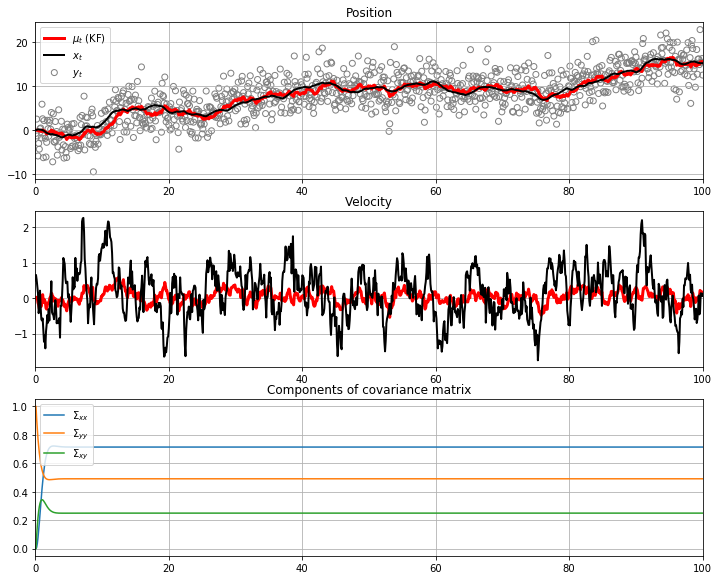

In [27]:
# Plot the trajectory and the observations
# (assume no observation at y = 0 )

t = np.arange(params["T"]+1) * dt


fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,8))
fig.tight_layout()

ax1.scatter(t[1:],y[1:],color='grey',facecolors='none')
ax1.plot(t,mu[:,0],linewidth=3,color='red')
ax1.plot(t,x[:,0],'black',linewidth=2)

ax1.legend([r'$\mu_t$ (KF)',r'$x_t$',r'$y_t$'])
ax1.grid(True)
ax1.set_xlim(0,t[-1])
ax1.set_title('Position')


ax2.plot(t,mu[:,1],linewidth=3,color='red')
ax2.plot(t,x[:,1],'black',linewidth=2)
ax2.grid(True)
ax2.set_xlim(0,t[-1])
ax2.set_title('Velocity')

ax3.plot(t,Sigma[:,0,0])
ax3.plot(t,Sigma[:,1,1])
ax3.plot(t,Sigma[:,1,0])
ax3.set_xlim(0,t[-1])
ax3.legend([r'$\Sigma_{xx}$',r'$\Sigma_{yy}$',r'$\Sigma_{xy}$'])
ax3.grid(True)
ax3.set_title('Components of covariance matrix')

plt.show()